# Staining-based Segmentation

This notebook showcases end-to-end ssDNA staining-based cell segmentation. This is done in two broad steps.

1. Identify individual nuclei from the staining image.
2. (Optionally) Expand the nuclei labels to obtain cell labels.

Note that the second step is optional, as there is likely a tradeoff between cell purity (only using the nuclei ends up yielding purer single-cell RNA) and number of UMIs captured per cell (expanding the labels yields higher UMIs per cell).

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/Users/josephmin/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/josephmin/miniconda3/lib/python3.9/site-packages/dynamo/configuration.py:292: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)
/Users/josephmin/miniconda3/lib/python3.9/site-packages/dynamo/configuration.py:293: UserWarning: Trying to register the cmap 'darkblue' which already exists.
  plt.register_cmap("darkblue", darkblue_cmap)
/Users/josephmin/miniconda3/lib/python3.9/site-packages/dynamo/configuration.py:294: UserWarning: Trying to register the cmap 'darkgreen' which already exists.
  plt.register_cmap("darkgreen", darkgreen_cmap)
/Users/josephmin/miniconda3/lib/python3.9/site-packages/dynamo/configuration.py:295: UserWarning: Trying to register the cmap 'darkred' which already exists.
  plt.register_cmap("darkred", darkred_cmap)
/Users/josephmin/miniconda3/lib/python3.9/site-packages/dynamo/configuration.py:296: UserWarning: Trying to register the cmap 'darkpurple' which already exists.
  plt.register_cmap("darkpu

## Load the data

`st.io.read_bgi_agg` reads in aggregated UMI counts per pixel. By also providing the staining image as the second argument, the image is loaded into the returned AnnData as well.

In [2]:
adata = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz', 'data/SS200000135IL-D1.ssDNA.tif', scale=0.5, scale_unit='um')
adata

AnnData object with n_obs × n_vars = 2001 × 2001
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

## 1. Nuclei segmentation

In this step, we segment and label individual nuclei using the staining image. Segmenting nuclei from staining result is relatively easy, since all we have to do is threshold the image to obtain a nuclei mask, and assign the mask to individual nuclei with watershed.

The `st.pp.segmentation.mask_nuclei_from_stain` performs the following steps.

1. Obtain a global background mask by applying a global thresholding technique using multi-class Otsu thresholding. Specifically, each pixel is classified into one of three bins, and we take all the pixels below the first threshold to be background.
2. Obtain a (noisy) nuclei mask by applying a local (adaptive) thresholding method, which uses the local neighborhood of each pixel to determine the threshold for that pixel. This method is usually accurate in nuclei-dense areas, but are noisy in sparse areas.
3. Take pixels that are not background (step 1) and are classified as nuclei (step 2) to be the nuclei mask.

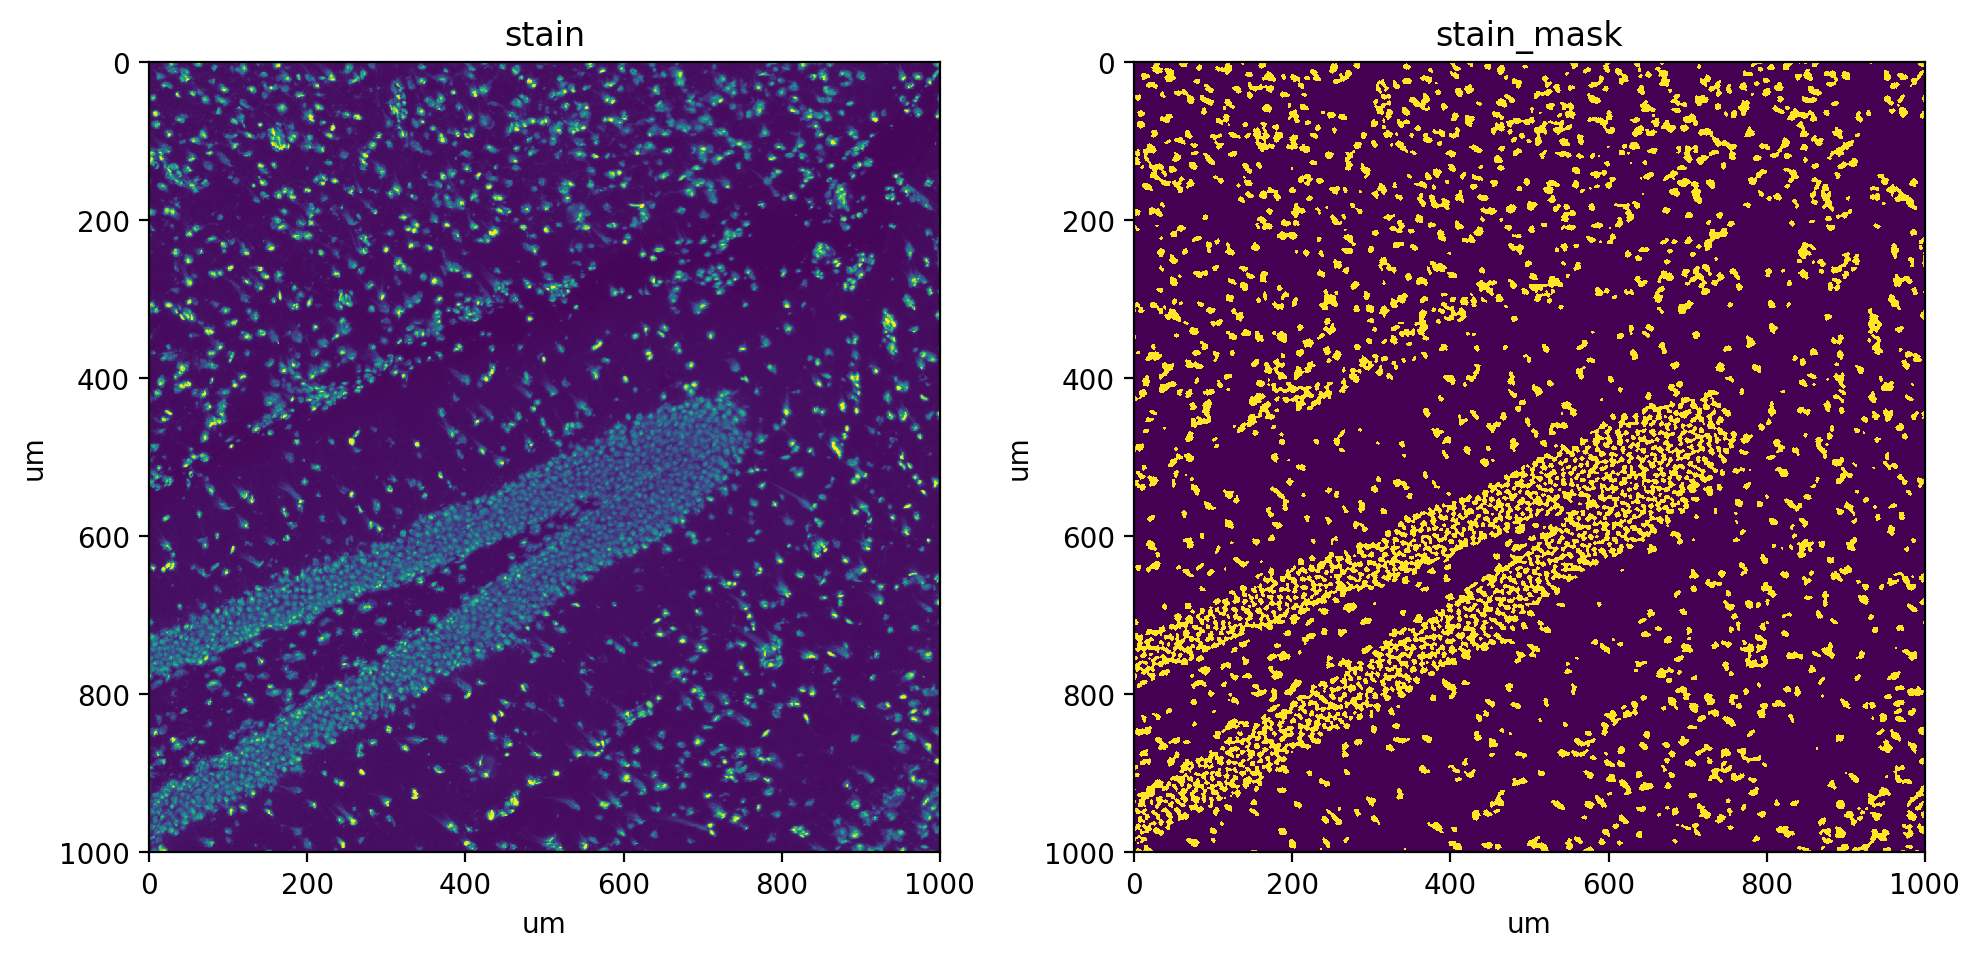

In [14]:
st.pp.segmentation.mask_nuclei_from_stain(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain', ax=axes[0])
st.pl.imshow(adata, 'stain_mask', ax=axes[1])

Once we have a mask of nuclei, we will attempt to label each individual nuclei using the Watershed algorithm, which consists of first finding Watershed markers that will serve as the starting points of the Watershed algorithm. Then, using these markers, we run Watershed.

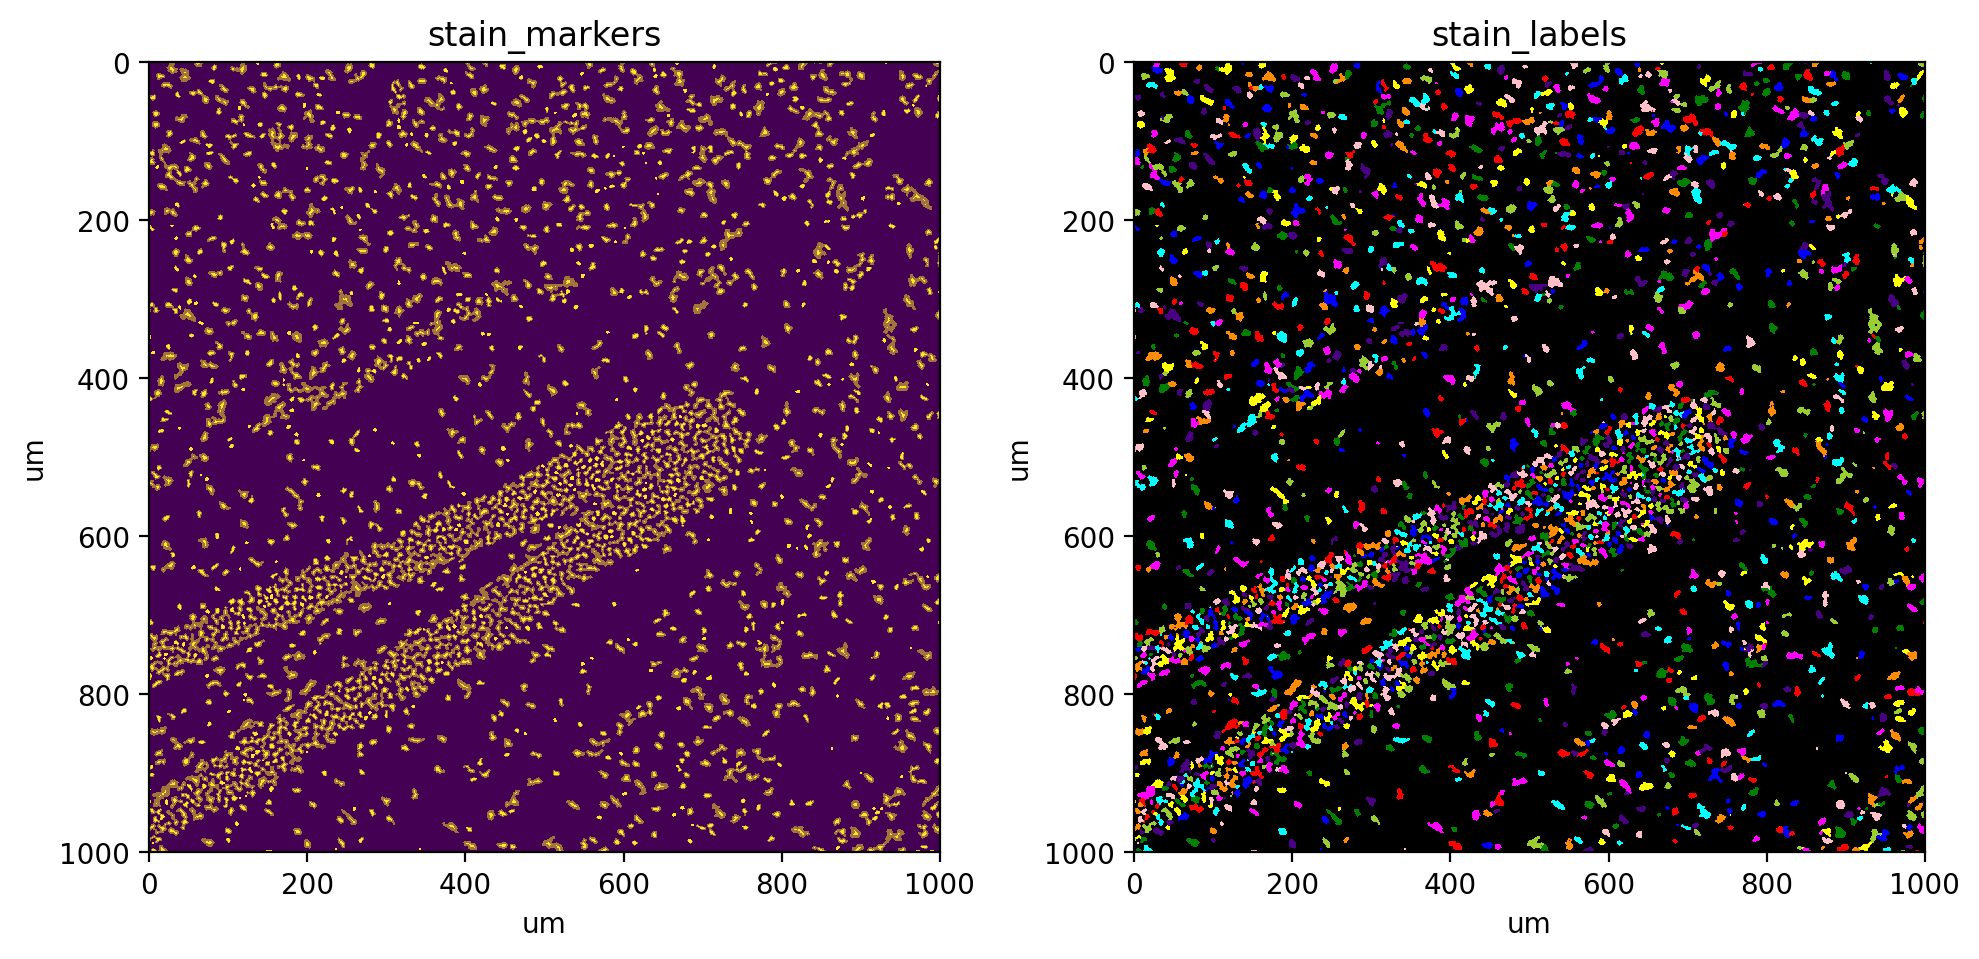

In [15]:
st.pp.segmentation.watershed_markers(adata)
st.pp.segmentation.watershed(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)

## 2. Expand nuclei to cells

The nuclei labels obtained above are labeled with high confidence. However, it is also possible to expand these labels into regions that we believe to be the cytoplasm. There are a few approaches.

1. Naively expand each of the nuclei labels by a certain distance.
2. Use the fact that ssDNA has low (but non-zero) affinity to cytoplasmic RNA. Therefore, we can obtain a "cell"/"cytoplasm" mask by thresholding the image with a more lenient global threshold. Then, we can run Watershed again, but this time with the nuclei lables as the starting markers.
3. Use total RNA signal to estimate regions that are likely to be cytoplasmic. Using this as our new mask, run Watershed again.

### 2.1. Naive expansion

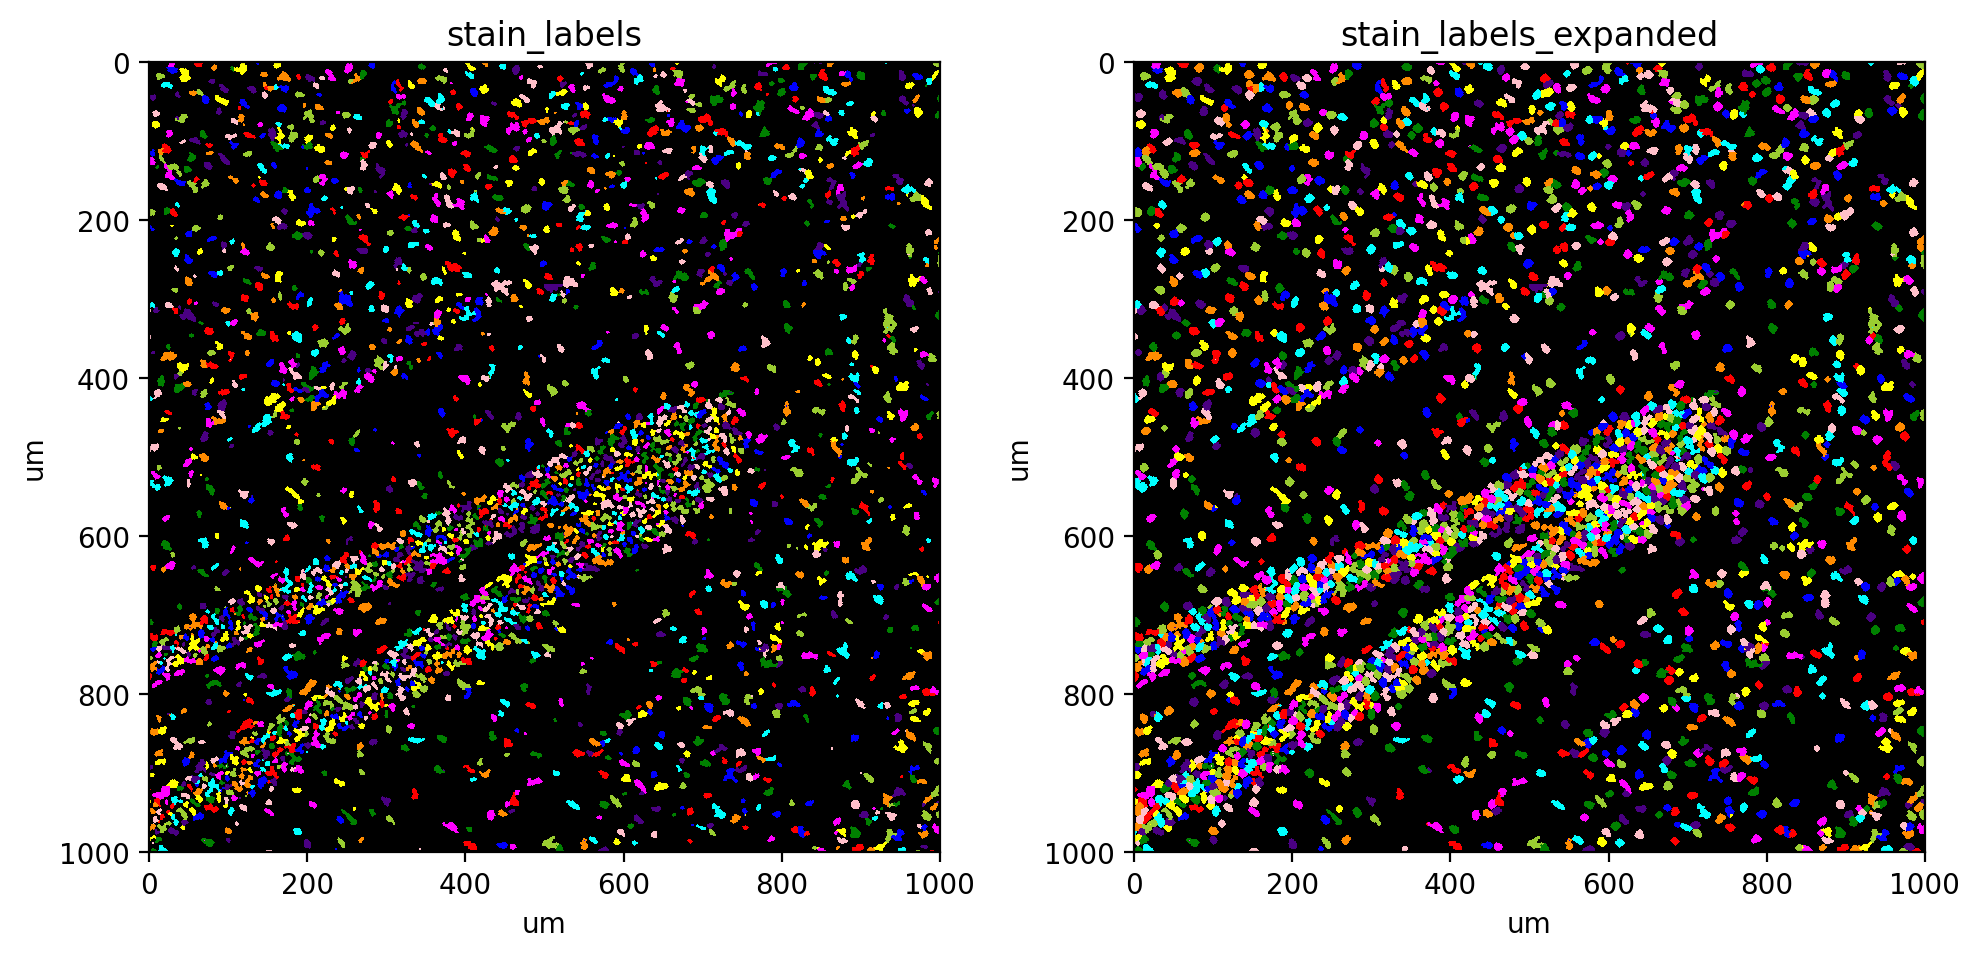

In [16]:
st.pp.segmentation.expand_labels(adata, 'stain', distance=5, max_area=400)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_labels', ax=axes[0], labels=True)
st.pl.imshow(adata, 'stain_labels_expanded', ax=axes[1], labels=True)

### 2.2. Thresholding + Watershed

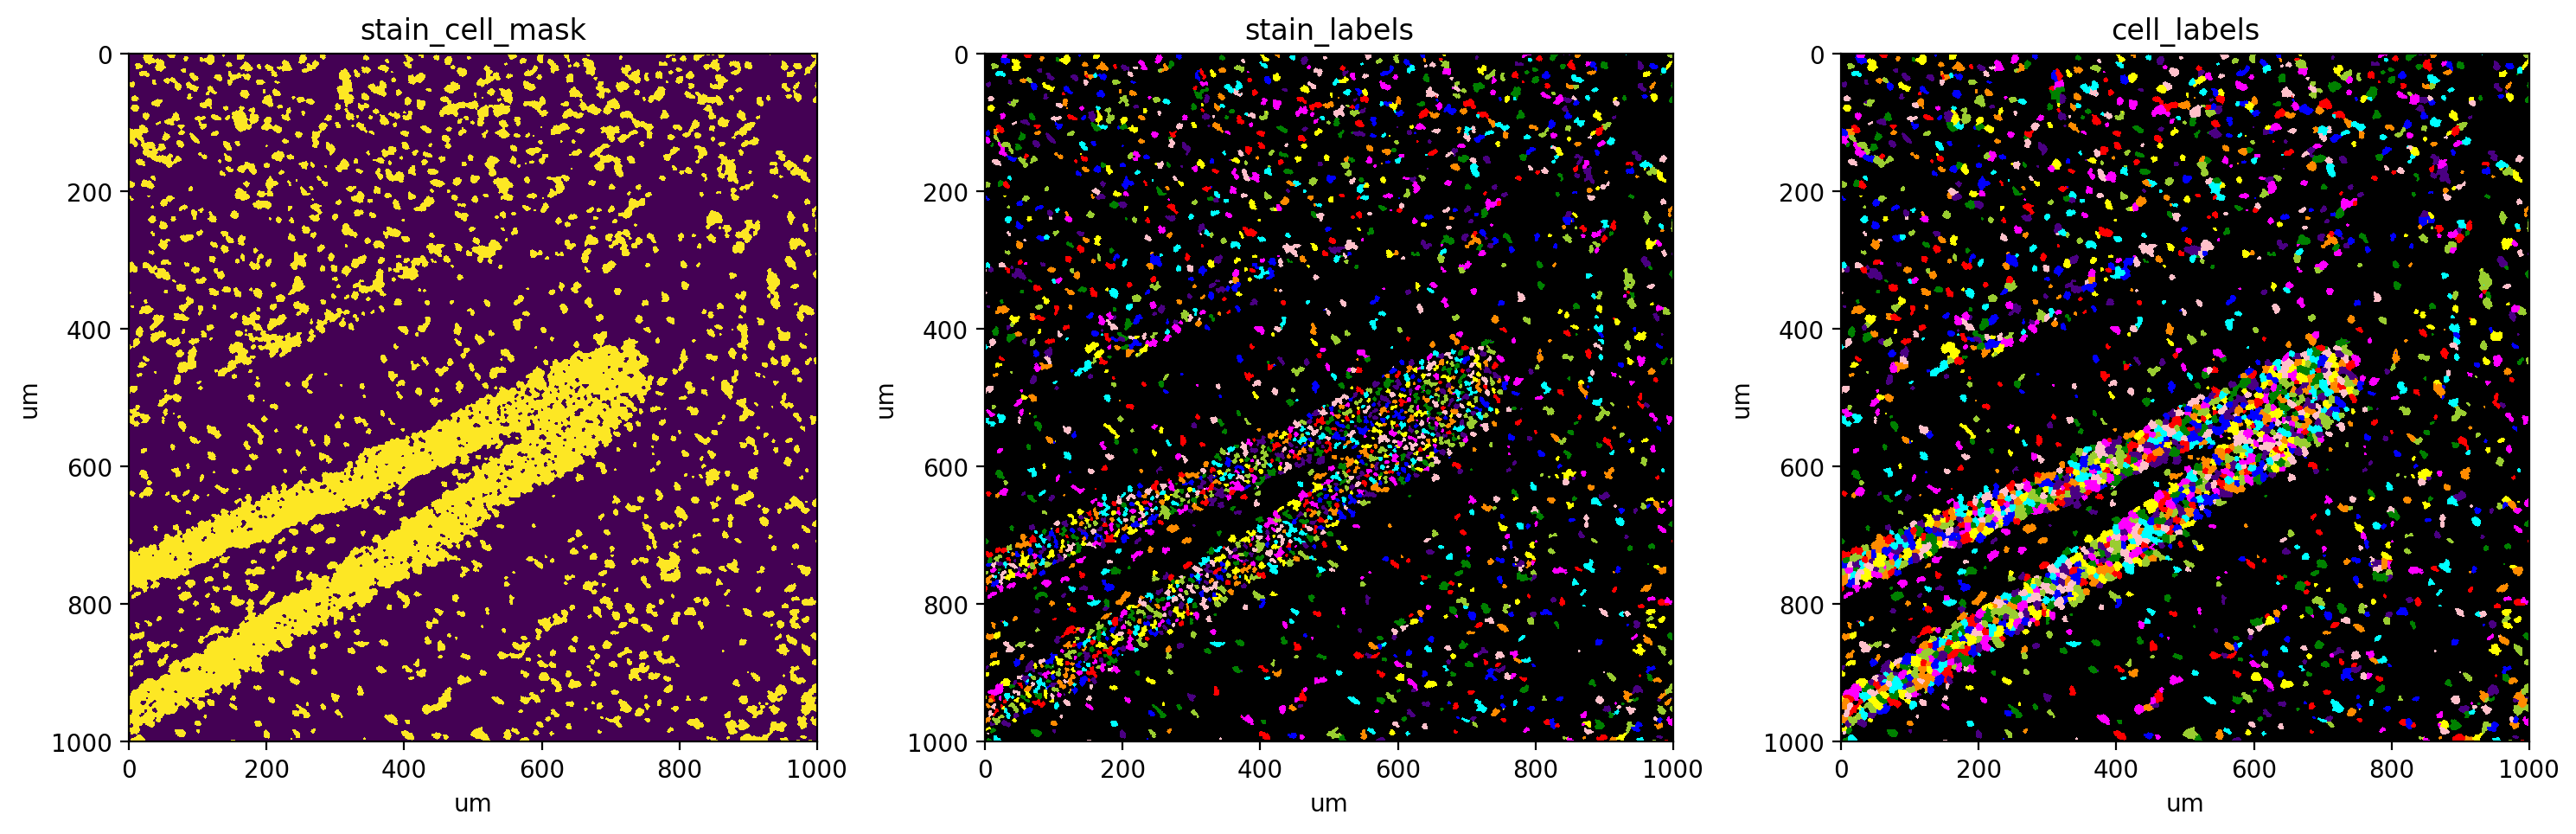

In [17]:
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.pp.segmentation.watershed(
    adata,
    'stain',
    mask_layer='stain_cell_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_cell_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)
st.pl.imshow(adata, 'cell_labels', ax=axes[2], labels=True)

### 2.3. Estimation + Watershed

TODO: This method is not viable until we can figure out a way to refine staining and RNA alignments.